### run.py

In [1]:

import argparse
import train
import test
import evaluate
import os
import json

#? IDK what to use these for. Were mentioned in run_experiment.sh
GPU_IDX=0
CUDA_DEVICE_ORDER="PCI_BUS_ID"
CUDA_VISIBLE_DEVICES=GPU_IDX


#? setup arg parser to pass in config info
parser = argparse.ArgumentParser()
parser.add_argument('--logdir', type=str, default='./log/', help='path to model save dir')
parser.add_argument('--loglevel', type=str, default='info', help='set level of logger')
parser.add_argument('--identifier', type=str, default='debug', help='unique run identifier')
parser.add_argument('--config', type=str, default='./configs/dfaust/config_dfaust.yaml', help='path to yaml config file')
parser.add_argument('--model_ckpt', type=str, default='000000.pt', help='checkpoint to load')
parser.add_argument('--fix_random_seed', action='store_true', default=False, help='fix random seed')
args = parser.parse_args([])


#? Manually set arg parser values here:
#? Comment out if you want to use terminal flags above instead (I just got tired of manually entering them in)

args.logdir = './log/'
args.loglevel = 'debug'
args.identifier = f'config_msr_action3d_temporal_0'
args.config = f'configs\msr-action3d\{args.identifier}.yaml'
args.model_ckpt = '000000.pt'
args.fix_random_seed = True
print('args', args)

best = json.load(open(os.path.join(args.logdir, args.identifier, 'best_model_list.json')))
args.model_ckpt = best[-1]['best']

c:\Users\Efran\anaconda3\envs\tpatches_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


args Namespace(config='configs\\msr-action3d\\config_msr_action3d_temporal_0.yaml', fix_random_seed=True, identifier='config_msr_action3d_temporal_0', logdir='./log/', loglevel='debug', model_ckpt='000000.pt')


In [2]:
args.model_ckpt

'best_000064_0.pt'

### evaluate

In [22]:
# Author: Yizhak Ben-Shabat (Itzik), 2020
# evaluate action recognition performance using acc and mAp

import os
import pandas as pd
import argparse
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import utils
from evaluation import eval_utils
from datasets import build_dataset
import matplotlib.pyplot as plt
from evaluation.eval_detection import ANETdetection
from evaluation.eval_classification import ANETclassification
import sklearn
import yaml
#import wandb

import logging

def create_basic_logger(logdir, level = 'info'):
    print(f'Using logging level {level} for evaluate.py')
    global logger
    logger = logging.getLogger('eval_logger')
    
    #? set logging level
    if level.lower() == 'debug':
        logger.setLevel(logging.DEBUG)
    elif level.lower() == 'info':
        logger.setLevel(logging.INFO)
    elif level.lower() == 'warning':
        logger.setLevel(logging.WARNING)
    elif level.lower() == 'error':
        logger.setLevel(logging.ERROR)
    elif level.lower() == 'critical':
        logger.setLevel(logging.CRITICAL)
    else:
        logger.setLevel(logging.INFO)
    
    #? create handlers
    print('---------------------- ', os.path.join(logdir, "log_eval.log"))
    file_handler = logging.FileHandler(os.path.join(logdir, "log_eval.log"))
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    
    stream_handler = logging.StreamHandler()
    #stream_handler.setLevel(logging.INFO)
    #stream_handler.setFormatter(stream_handler)
    logger.addHandler(stream_handler)
    return logger

#### eval_msr

In [10]:
cfg = yaml.safe_load(open(os.path.join(args.logdir, args.identifier, 'config.yaml')))
#run = wandb.init(entity=cfg['WANDB']['entity'], project=cfg['WANDB']['project'], id=cfg['WANDB']['id'], resume='must')
#wandb.define_metric("eval/step")
#wandb.define_metric("eval/*", step_metric="eval/step")
logger = create_basic_logger(logdir = os.path.join(args.logdir, args.identifier), level = args.loglevel)

Using logging level debug for evaluate.py
----------------------  ./log/config_msr_action3d_temporal_0\log_eval.log


In [11]:
results_path = os.path.join(args.logdir, args.identifier, 'results/')
subset = cfg['TESTING']['set']
data_name = cfg['DATA']['name']

# load the gt and predicted data
training_ = True if subset == 'train' else False

In [12]:
dataset = build_dataset(cfg, training=training_)
#gt_labels = dataset.action_labels

In [51]:
holdout_test_json = json.load(open(os.path.join(args.logdir, args.identifier, 'holdout_test_pred_score.json')))
best_model_json = json.load(open(os.path.join(args.logdir, args.identifier, 'best_model_list.json')))
test_results_json = json.load(open(os.path.join(args.logdir, args.identifier, 'test_result_list.json')))
train_results_json = json.load(open(os.path.join(args.logdir, args.identifier, 'train_result_list.json')))


In [52]:
holdout_test_df = pd.DataFrame(holdout_test_json)
best_model_df = pd.DataFrame(best_model_json)
test_results_df = pd.DataFrame(test_results_json)
train_results_df = pd.DataFrame(train_results_json)

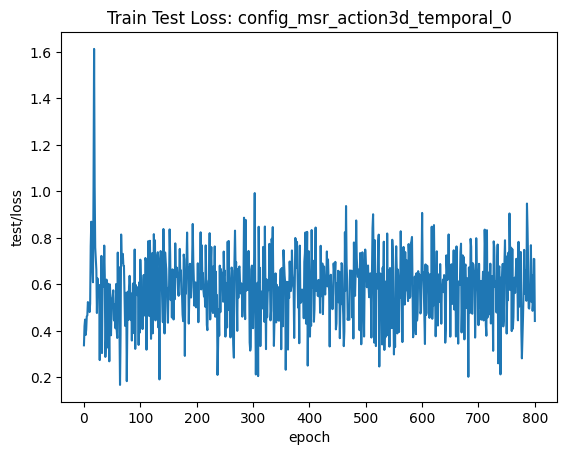

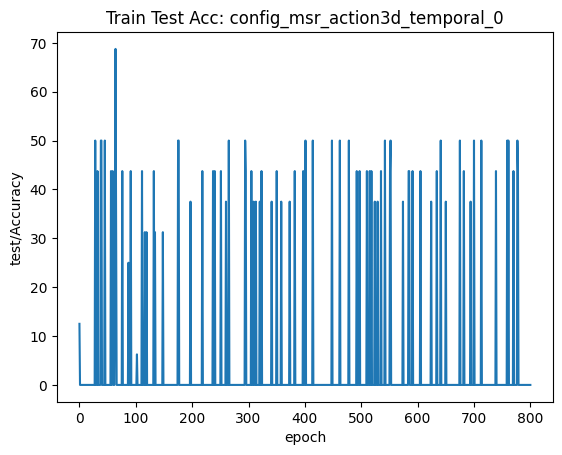

In [72]:
test_fig1, test_ax1 = plt.subplots()
test_ax1.plot(test_results_df.index, test_results_df['test/loss'])
test_ax1.set_ylabel('test/loss')
test_ax1.set_xlabel('epoch')
test_ax1.set_title(f'Train Test Loss: {args.identifier}')
test_fig1.savefig(os.path.join(args.logdir, args.identifier, 'results','train_test_loss_graph.png'))


test_fig2, test_ax2 = plt.subplots()
test_ax2.plot(test_results_df.index, test_results_df['test/Accuracy'])
test_ax2.set_ylabel('test/Accuracy')
test_ax2.set_xlabel('epoch')
test_ax2.set_title(f'Train Test Acc: {args.identifier}')
test_fig2.savefig(os.path.join(args.logdir, args.identifier, 'results','train_test_acc_graph.png'))

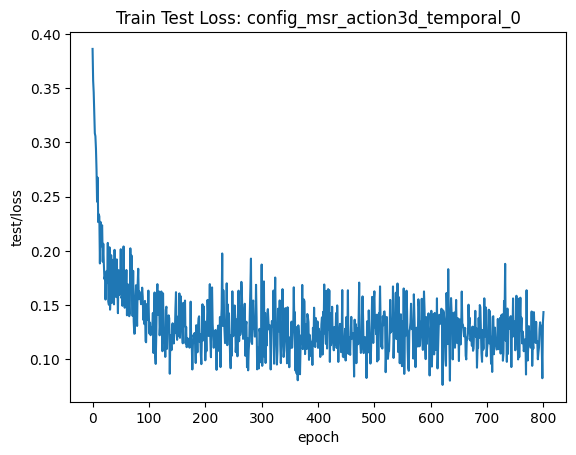

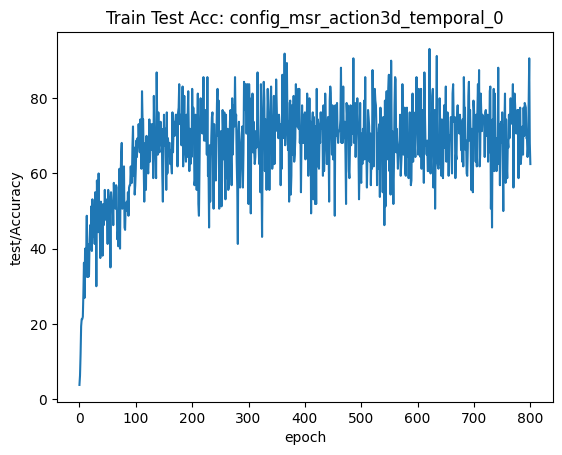

In [71]:
train_fig1, train_ax1 = plt.subplots()
train_ax1.plot(train_results_df.index, train_results_df['train/loss'])
train_ax1.set_ylabel('test/loss')
train_ax1.set_xlabel('epoch')
train_ax1.set_title(f'Train Test Loss: {args.identifier}')
train_fig1.savefig(os.path.join(args.logdir, args.identifier, 'results','train_loss_graph.png'))


train_fig2, train_ax2 = plt.subplots()
train_ax2.plot(train_results_df.index, train_results_df['train/Accuracy'])
train_ax2.set_ylabel('test/Accuracy')
train_ax2.set_xlabel('epoch')
train_ax2.set_title(f'Train Test Acc: {args.identifier}')
train_fig2.savefig(os.path.join(args.logdir, args.identifier, 'results','train_acc_graph.png'))

{'model': 'config_msr_action3d_temporal_0', 'accuracy': 5.0245098039215685}

In [80]:
data = {"model": args.identifier, "accuracy": holdout_test_df['acc'].mean()}


if os.path.exists('holdout_scores.json') == False:
    with open('holdout_scores.json', 'w') as f:
        json.dump([data], f)
else:
    holdout_scores = json.load(open('holdout_scores.json'))
    holdout_scores.append(data)
    with open('holdout_scores.json', 'w') as f:
        json.dump(holdout_scores, f)